# 一、背景介绍

在OCR文本检测和识别中，图像的质量的高低直接影响着检测和识别的性能，低质量的图像往往存在如倾斜、褶皱、模糊、虚景等问题，因此图像预处理是OCR任务中重要的环节。本节将重点介绍图像预处理中的数据增广(Image Augmentationa)、二值化(Image Binarization)和去噪的常用算法。数据增广是深度学习中常用的优化技巧之一，通过对训练数据进行一系列变换增加样本数量及样本多样性，使得模型具有更强的泛化能力。二值化处理将图像转为黑白效果图，使得文字和背景分离，有助于文字检测和识别。去噪处理能够去除图片中的噪声干扰(如椒盐噪声、高斯噪声等)，首先需要认识噪声的类型，再结合噪声特点选择合适的去噪方法。二值化和去噪是传统OCR方法常用的预处理算法，在印刷体和扫描文档上取得了较好的效果，也可以在预处理算法后得到较清晰的图片，再去使用基于深度学习的检测和识别方法。

本节筛选了一些常用数据增广、二值化、去噪方法，如下3个表格所示。

<center>表1 数据增广方法</center>
<center>

| 数据增广  | 方法 |
| -------- | -------- |
|  标准数据增广 | 旋转、透视变换、模糊、高斯噪声、随机裁剪等方法 |
|  图像变换类 | AutoAugment、RandAugment、TimmAutoAugment |
|  图像裁剪类 | CutOut、RandErasing、HideAndSeek、GridMask |
|  图像混叠  | Mixup、Cutmix |
  
</center>


<center>表2 二值化方法</center>
<center>
  
| 二值化  | 方法 |
| -------- | -------- |
| 全局阈值法  | 固定阈值法、Otus |
| 局部阈值法  | 自适应阈值法、NiBlack、Sauvola、Bernsen |
| 深度学习方法  | U-Net、Grid LSTM、全卷积神经网络等 |
  
</center>
  
<center>表3 去噪方法</center>
<center>
  
| 去噪  | 方法 |
| -------- | -------- |
| 空间域滤波  | 均值滤波、高斯滤波、中值滤波、双边滤波、非局部均值算法(Non-Local Means,NLM) |
| 变换域滤波  | 傅里叶变换、小波变换 |
| BM3D  | BM3D |
| 深度学习  | DnCNNs、FFDNet、MPRNet |

</center>

注：表格中文章统计或有遗漏，如有疑问，请在[链接](https://github.com/PaddlePaddle/PaddleOCR/issues)中联系我们

# 二、数据增广

OCR手写和场景等文本检测与识别面临着形态各异、背景复杂、文字模糊等众多问题。因此，训练一个鲁棒的识别模型需要大量的数据来覆盖尽可能多的场景。与数据收集和标注相比，数据增广是一种成本较低的方式，且能够有效提升模型的鲁棒性。本节主要介绍一些标准数据增广方法，如颜色空间转换、模糊、噪声等，还有很多改进的图像增广策略，还有一些在标准增广方法的不同阶段插入一定的操作，我们将这些操作大致分为了四类：
* 标准数据增广：常用的旋转、透视变换、模糊、高斯噪声、随机裁剪等方法；
* 图像变换类，即对 RandCrop 后的图像进行一些变换: AutoAugment，RandAugment；
* 图像裁剪类，即对Transpose 后的图像进行一些裁剪: CutOut，RandErasing，HideAndSeek，GridMask；
* 图像混叠类，即对 Batch 后的数据进行混合: Mixup，Cutmix。

In [ ]:
首先，导入实验需要的模块或包。

In [ ]:
import numpy as np
import cv2
import random
# 在notebook中使用matplotlib.pyplot绘图时，需要添加该命令进行显示
%matplotlib inline
import matplotlib.pyplot as plt

我们读取一张图像作为实验的样例，同时输出图像的形状、展示图像。

(104, 495, 3)


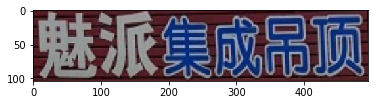

In [ ]:
img = cv2.imread('/home/aistudio/preprocess/test_imgs/ch_street_rec_1.png')
print(img.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

大部分数据增广方法生成的图像都有一定的随机性，为了方便观察数据增广的效果，下面定义一个绘图函数`show_img`。这个函数展示输入图像`img`和经过数据增广方法之后的图像`new_img`。

In [ ]:
def show_img(img, new_img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title('origin')

    plt.subplot(1,2,2)
    plt.imshow(new_img_rgb)
    plt.title('transform')

    plt.show()

## 2.1 标准数据增广

1）颜色空间转换(cvtColor)：将图像从一个颜色空间转换到另一个颜色空间。

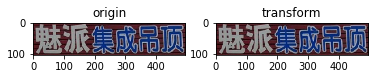

In [ ]:
def flag():
    """
    flag
    """
    return 1 if random.random() > 0.5000001 else -1

def cvtColor(img):
    """
    cvtColor
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    delta = 0.001 * random.random() * flag()
    hsv[:, :, 2] = hsv[:, :, 2] * (1 + delta)
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img

cvtcolor_img = cvtColor(img)
show_img(img, cvtcolor_img)

2）模糊(Blur)：通过减少图片各点像素值的差距，达到模糊效果。我们通过`cv2.GaussianBlur`实现高斯模糊方法，参数分别表示图片数组、核的宽度和高度、X方向的高斯核标准差，其中核的宽度和高度取值越大，图像越模糊。

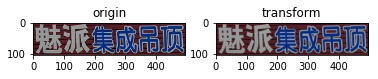

In [ ]:
def blur(img):
    """
    blur
    """
    h, w, _ = img.shape
    if h > 10 and w > 10:
        return cv2.GaussianBlur(img, (5, 5), 1)
    else:
        return img
blur_img = blur(img)
show_img(img, blur_img)

3）抖动：通过随机改变图像像素点的值达到抖动的效果。

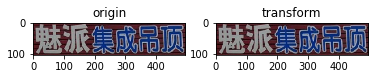

In [ ]:
def jitter(img):
    """
    jitter
    """
    w, h, _ = img.shape
    if h > 10 and w > 10:
        thres = min(w, h)
        s = int(random.random() * thres * 0.01)
        src_img = img.copy()
        for i in range(s):
            img[i:, i:, :] = src_img[:w - i, :h - i, :]
        return img
    else:
        return img
jitter_img = jitter(img)
show_img(img,jitter_img)

4）噪声(noise)：噪声是真实图像中不可预料的因素，因此通过添加噪声来模拟真实数据，这是一种简单有效的数据增广方法。通常使用的噪声方法包含高斯噪声、椒盐噪声等，这里以高斯噪声为例展示图像添加噪声过程。`mean`表示均值，`var`表示方差，方差越大，噪声越大。

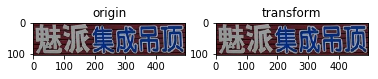

In [ ]:
def add_gasuss_noise(image, mean=0, var=0.1):
    """
    Gasuss noise
    """

    noise = np.random.normal(mean, var**0.5, image.shape)
    out = image + 0.5 * noise
    out = np.clip(out, 0, 255)
    out = np.uint8(out)
    return out
noise_img = add_gasuss_noise(img)
show_img(img, noise_img)

5）随机裁剪(Random Crop)：从当前图像中随机选择一个区域并将其裁剪出来，获得一个新的样本。考虑文本识别时，图片高度比较小，我们设置了top_min和top_max限制裁剪的尺寸。

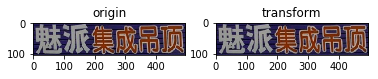

In [ ]:
def get_crop(image):
    """
    random crop
    """
    h, w, _ = image.shape
    top_min = 1
    top_max = 8
    top_crop = int(random.randint(top_min, top_max))
    top_crop = min(top_crop, h - 1)
    crop_img = image.copy()
    ratio = random.randint(0, 1)
    if ratio:
        crop_img = crop_img[top_crop:h, :, :]
    else:
        crop_img = crop_img[0:h - top_crop, :, :]
    return crop_img
crop_img = get_crop(img)
show_img(crop_img, img)

6）透视变换(Perspective)：通过投影矩阵将一幅图像投影到一个新的平面上。

In [ ]:
from warp_mls import WarpMLS

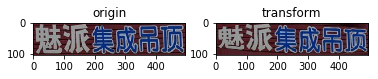

In [ ]:
def tia_perspective(src):
    img_h, img_w = src.shape[:2]

    thresh = img_h // 2

    src_pts = list()
    dst_pts = list()

    src_pts.append([0, 0])
    src_pts.append([img_w, 0])
    src_pts.append([img_w, img_h])
    src_pts.append([0, img_h])

    dst_pts.append([0, np.random.randint(thresh)])
    dst_pts.append([img_w, np.random.randint(thresh)])
    dst_pts.append([img_w, img_h - np.random.randint(thresh)])
    dst_pts.append([0, img_h - np.random.randint(thresh)])

    trans = WarpMLS(src, src_pts, dst_pts, img_w, img_h)
    dst = trans.generate()

    return dst
perspective_img = tia_perspective(img)
show_img(img, perspective_img)

7）颜色反转(Reverse)：将图像颜色进行反转，图像最大取值减去源图像，即可得到反转的图像。反转后亮的地方变暗，暗的地方变亮。

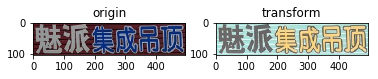

In [ ]:
def reverse(img):
    new_img = 255 - img
    return new_img
reverse_img = reverse(img)
show_img(img,reverse_img)

8）TIA[1]也是一个有效的数据增广方法，该方法首先在图像上初始化一组基准点。然后用几何变换随机移动这些点，生成新的图像。
<center><img src='https://ai-studio-static-online.cdn.bcebos.com/5347b9b58f1f44f68224076c52cc74ea70a5f39e289646b197ba150215c319ea' width='700'></center>
<center>图1 TIA数据增广示意图</center>

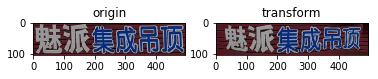

In [ ]:
def tia_distort(src, segment=4):
    img_h, img_w = src.shape[:2]

    cut = img_w // segment
    thresh = cut // 3

    src_pts = list()
    dst_pts = list()

    src_pts.append([0, 0])
    src_pts.append([img_w, 0])
    src_pts.append([img_w, img_h])
    src_pts.append([0, img_h])

    dst_pts.append([np.random.randint(thresh), np.random.randint(thresh)])
    dst_pts.append(
        [img_w - np.random.randint(thresh), np.random.randint(thresh)])
    dst_pts.append(
        [img_w - np.random.randint(thresh), img_h - np.random.randint(thresh)])
    dst_pts.append(
        [np.random.randint(thresh), img_h - np.random.randint(thresh)])

    half_thresh = thresh * 0.5

    for cut_idx in np.arange(1, segment, 1):
        src_pts.append([cut * cut_idx, 0])
        src_pts.append([cut * cut_idx, img_h])
        dst_pts.append([
            cut * cut_idx + np.random.randint(thresh) - half_thresh,
            np.random.randint(thresh) - half_thresh
        ])
        dst_pts.append([
            cut * cut_idx + np.random.randint(thresh) - half_thresh,
            img_h + np.random.randint(thresh) - half_thresh
        ])

    trans = WarpMLS(src, src_pts, dst_pts, img_w, img_h)
    dst = trans.generate()

    return dst

distort_img = tia_distort(img)
show_img(img, distort_img)

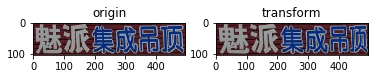

In [ ]:
def tia_stretch(src, segment=4):
    img_h, img_w = src.shape[:2]

    cut = img_w // segment
    thresh = cut * 4 // 5

    src_pts = list()
    dst_pts = list()

    src_pts.append([0, 0])
    src_pts.append([img_w, 0])
    src_pts.append([img_w, img_h])
    src_pts.append([0, img_h])

    dst_pts.append([0, 0])
    dst_pts.append([img_w, 0])
    dst_pts.append([img_w, img_h])
    dst_pts.append([0, img_h])

    half_thresh = thresh * 0.5

    for cut_idx in np.arange(1, segment, 1):
        move = np.random.randint(thresh) - half_thresh
        src_pts.append([cut * cut_idx, 0])
        src_pts.append([cut * cut_idx, img_h])
        dst_pts.append([cut * cut_idx + move, 0])
        dst_pts.append([cut * cut_idx + move, img_h])

    trans = WarpMLS(src, src_pts, dst_pts, img_w, img_h)
    dst = trans.generate()

    return dst

stretch_img = tia_stretch(img)
show_img(img, stretch_img)

## 2.2 图像变换类

图像变换类指的是对RandCrop后的图像进行一些变换，主要包括：

* AutoAugment
* RandAugment
* TimmAutoAugment

不同于常规的人工设计图像增广方式，AutoAugment[2] 是在一系列图像增广子策略的搜索空间中通过搜索算法找到的适合特定数据集的图像增广方案。针对 ImageNet 数据集，最终搜索出来的数据增强方案包含 25 个子策略组合，每个子策略中都包含两种变换，针对每幅图像都随机的挑选一个子策略组合，然后以一定的概率来决定是否执行子策略中的每种变换。我们以 图2 中的8幅图片作为测试图片，观察数据变换情况。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/f45c1b1ddef0441c98407258899c194037738d3e818048168dd7c514ca787542' width='700'></center>
<center>图2 测试原图</center>

经过AutoAugment数据增强后结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/d8bdf2a8d77240fe8082271dfa1d2e213975610270ef45a585ee44f276e67f12' width='700'></center>
<center>图3 AutoAugment数据增广示意图</center>

AutoAugment[3] 的搜索方法比较暴力，直接在数据集上搜索针对该数据集的最优策略，其计算量很大。在 RandAugment 文章中作者发现，一方面，针对越大的模型，越大的数据集，使用 AutoAugment 方式搜索到的增广方式产生的收益也就越小；另一方面，这种搜索出的最优策略是针对该数据集的，其迁移能力较差，并不太适合迁移到其他数据集上。

在 RandAugment 中，作者提出了一种随机增广的方式，不再像 AutoAugment 中那样使用特定的概率确定是否使用某种子策略，而是所有的子策略都会以同样的概率被选择到，论文中的实验也表明这种数据增强方式即使在大模型的训练中也具有很好的效果。

经过RandAugment数据增强后结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/d5b6ff59029f4a05beacb59ec8f2a8356e6e3734fae5495dbc0a88877212e128' width='700'></center>
<center>图4 RandAugment数据增广示意图</center>

## 2.3 图像裁剪类

图像裁剪类主要是对Transpose后的图像进行一些裁剪，并将裁剪区域的像素值置为特定的常数（默认为0），主要包括：

* CutOut
* RandErasing
* HideAndSeek
* GridMask

图像裁剪的这些增广并非一定要放在归一化之后，也有不少实现是放在归一化之前的，也就是直接对 uint8 的图像进行操作，两种方式的差别是：如果直接对 uint8 的图像进行操作，那么再经过归一化之后被裁剪的区域将不再是纯黑或纯白（减均值除方差之后像素值不为0）。而对归一后之后的数据进行操作，裁剪的区域会是纯黑或纯白。上述的裁剪变换思路是相同的，都是为了解决训练出的模型在有遮挡数据上泛化能力较差的问题，不同的是他们的裁剪方式、区域不太一样。

Cutout[4] 可以理解为 Dropout 的一种扩展操作，不同的是 Dropout 是对图像经过网络后生成的特征进行遮挡，而 Cutout 是直接对输入的图像进行遮挡，相对于Dropout对噪声的鲁棒性更好。作者在论文中也进行了说明，这样做法有以下两点优势：

(1) 通过 Cutout 可以模拟真实场景中主体被部分遮挡时的分类场景；

(2) 可以促进模型充分利用图像中更多的内容来进行分类，防止网络只关注显著性的图像区域，从而发生过拟合。经过Cutout数据增强后结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/08e1dfaa2d544997a0f1b60f7b95d8f013595b765ff74af88e69e8ba5dda4695' width='700'></center>
<center>图5 CutOut数据增广示意图</center>


RandomErasing[5] 与 Cutout 方法类似，同样是为了解决训练出的模型在有遮挡数据上泛化能力较差的问题，作者在论文中也指出，随机裁剪的方式与随机水平翻转具有一定的互补性。作者也在行人再识别（REID）上验证了该方法的有效性。与Cutout不同的是，在RandomErasing中，图片以一定的概率接受该种预处理方法，生成掩码的尺寸大小与长宽比也是根据预设的超参数随机生成。经过RandomErasing数据增强后结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/05cc1447f29b4714a538b0908ac930928b80c60e5b3846c69fdf5bba16016c99' width='700'></center>
<center>图6 RandomErasing数据增广示意图</center>

HideAndSeek[6]论文将图像分为若干块区域(patch)，对于每块区域，都以一定的概率生成掩码，经过HideAndSeek数据增强后结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/dea36a446d48431789067660e1068593efc1949643ce44da8d7ecd0ae712ac1c' width='700'></center>
<center>图7 HideAndSeek数据增广示意图</center>

GridMask[7]是通过生成一个与原图分辨率相同的掩码，并将掩码进行随机翻转，与原图相乘，从而得到增广后的图像，通过超参数控制生成的掩码网格的大小。在训练过程中，有两种以下使用方法：

* 设置一个概率p，从训练开始就对图片以概率p使用GridMask进行增广。
* 一开始设置增广概率为0，随着迭代轮数增加，对训练图片进行GridMask增广的概率逐渐增大，最后变为p。

论文中验证上述第二种方法的训练效果更好一些。经过GridMask数据增强后结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/6dd466a8bd3242d6b7dc13104406aee358a213e1829644718b677734e0e3c569' width='700'></center>
<center>图8 GridMask数据增广示意图</center>

## 2.4 图像混叠

图像混叠主要对 Batch 后的数据进行混合，包括：

* Mixup
* Cutmix

前文所述的图像变换与图像裁剪都是针对单幅图像进行的操作，而图像混叠是对两幅图像进行融合，生成一幅图像，两种方法的主要区别为混叠的方式不太一样。

Mixup[8] 是最先提出的图像混叠增广方案，其原理简单、方便实现，不仅在图像分类上，在目标检测上也取得了不错的效果。为了便于实现，通常只对一个 batch 内的数据进行混叠，在 Cutmix 中也是如此。经过Mixup数据增强结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/611228bc326a4108b272b4a07eb67f9934430804aeae4fa09ca222295c27fa76' width='700'></center>
<center>图9 Mixup数据增广示意图</center>


与 Mixup 直接对两幅图进行相加不一样，Cutmix[9] 是从一幅图中随机裁剪出一个 ROI，然后覆盖当前图像中对应的区域。经过Cutmix数据增强后结果如下图所示。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/6f511244c5a14fc9a2ccda5f506fefb09e7abfade7cb4aa8a2f952be3ec00653' width='700'></center>

<center>图10 Cutmix数据增广示意图</center>

# 三、图像二值化

图像二值化(Image Binarization)是指将图像上的像素点的灰度值设置为0或255，使整个图像呈现出明显的黑白效果。二值图像的每个像素只有两种取值：0、255，0表示黑色，255表示白色。图像二值化能够降低噪声带来的干扰，同时消除背景干扰，从而凸显目标的轮廓。如果二值化方法能很好地区分前景和背景，那么就能够提升OCR文字识别性能。目前图像二值化方法有很多种，我们主要分为全局阈值法(Global Binarization)、局部阈值方法(Local Binarization)、基于深度学习方法。本节将对以上三大类二值化方法依次展开讨论。

## 3.1 全局阈值方法

全局阈值法是指对整幅图像像素都用相同的阈值做全局处理，常用的方法有固定阈值法、Otus等。

固定阈值法对所有像素都使用一个固定的数字作为全局阈值T，如果当前像素点的像素值大于等于阈值T，则该点赋值255，否则赋值0。通常需要设定不同的阈值进行实验观察二值化效果，且为不同的图像确定最优阈值是一件困难的事情，同一张图片在不同阈值下的二值化效果如 **图11** 所示。为了克服这个问题，日本学者Nobuyuki Otsu于1979年提出了一种自适应的阈值确定方法Otsu[10]。Otsu把图像分为前景和背景，而像素之间的方差越大，相关性越低，前景和背景越分明。因此将图像每一个像素灰度值上下之间的像素的方差求出来，找到方差最大的灰度值，即为二值化阈值。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/92dc83ef9e154fd1a91bb5f9c42eeb2300aa911ebe384a66b72d97ff069b314e' width='700'></center>
<center>图11 不同阈值二值化效果</center>

## 3.2 局部阈值方法

如果图像存在光照不均匀等问题，使用基于全局阈值的二值化方法就无法达到预期的二值化效果，这个情况下就要使用局部阈值的二值化方法。局部阈值方法。常见的图像二值化局部阈值方法有自适应阈值算法[11]、NiBlack[12]、Sauvola[13]等。

自适应阈值算法就是以图像上一个像素点为中心设置一个大小为 $s*s$ 滑窗，滑窗扫过整幅图像，每滑动一次就对当前窗口内的像素求均值并将均值作为局部阈值$T$。如果当前窗口内的某一像素值小于局部阈值$T/100$，这个像素值被赋值0；如果大于局部阈值$T/100$，赋值255，效果如 **图12** 所示。 NiBlack计算图像局部区域内像素的均值$m$与方差$s$之后，通过$T=m+k*s$计算局部阈值，$k$表示修正系数，一般取值0~1之间，最后根据阈值T进行二值化处理。Sauvola是在NiBlack算法基础上进行改进的，通过$T=m ·[1 + k · (\frac{s}{R} -1 )]$计算局部阈值，其中R是方差的动态范围，若当前输入图像为8位灰度图像，则R=128。在光照不均匀等情况下，Sauvola比NiBlack表现更好。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/5ad77abadfd9448f83fe1cfd0d75908b2665d79f42104e0880c80ba85a695265' width='500'></center>
<center>图12 自适应二值化效果</center>

## 3.3 深度学习方法

传统的全局、局部二值化方法很难设定合适的阈值，这就造成图像二值化效果不好。随着深度学习的不断发展，一些学者开始尝试使用神经网络对图像进行二值化。

Pratikakis I等人[14]在ICDAR2017 DIBCO比赛中使用U-Net卷积神经网络架构进行文档图像二值化，并获得冠军。Chris Tensmeyer等人[15]利用多尺度全卷积神经网络对文档图像进行二值化，效果如 **图13** 所示。Vo QN等人[16]中提出了一个分层的深度监督网络(hierarchical DSN)用于文档二值化，效果如 **图14** 所示。Westphal F等人[17]使用网格长短期记忆(Grid LSTM)网络实现二值化，然而它的性能低于方法[16]。Calvo-Zaragoza J等人[18]中使用深度编码器和解码器架构实现二值化。

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/d16098ec7484420bb0018769a68eba21afc242c269cc486181b91bfca1036c7e' width='500'></center>
<center>图13 全卷积神经网络二值化效果 </center>

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/12ef9efa627042309e8ce38d3df23521ececb634d5ee47e9a9fe17f2446b4d08' width='500'></center>
<center>图14 hierarchical DSN二值化效果</center>

# 四、 去噪

图像噪声是指存在于图像数据中不必要的或多余的干扰信息，噪声的存在会严重影响数据质量，因此通常需要对图像进行去噪处理。此外，我们在去噪的同时，还需要保持图像的细节。我们将分为四大类方法进行介绍：空间域滤波、变换域滤波、非局部滤波和基于神经网络的方法。

## 4.1 空间域滤波


空间域滤波是指在原图上直接进行数据运算，对像素值进行处理。常见的空间域滤波去噪算法有均值滤波、高斯滤波、中值滤波、双边滤波[19]、非局部均值算法(Non-Local Means,NLM)[20]等。

均值滤波使用像素点A领域内像素的平均值来代替像素点A原来的像素值，是典型的平滑线性滤波器。均值滤波器计算简单，对整幅图像起到平滑作用。但也存在缺陷，它不能很好地保留图像细节，从而导致图像变得模糊。高斯滤波也属于线性滤波器，是一种常用的滤波算法。经过高斯滤波后，图像每个像素点的值都由其本身和领域内的其它像素值经过加权后的平均值替代。相比于均值滤波，高斯滤波的平滑效果更柔和，边缘信息保留也更好，能够有效抑制高斯噪声。

中值滤波器用图像像素点邻域灰度值的中值来代替该像素点的像素值，是一种非线性滤波器，适用于处理椒盐噪声同时又能保留图像的边缘细节。双边滤波不仅考虑像素在空间的距离，还关注像素间的的相似程度、颜色强度等。

使用`OpenCV`库实现四种滤波器。


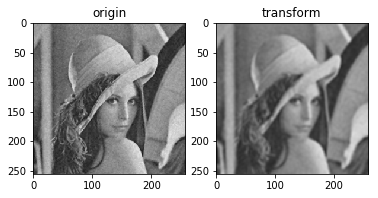

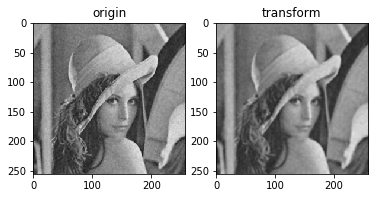

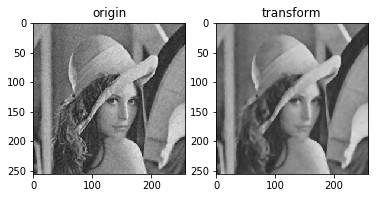

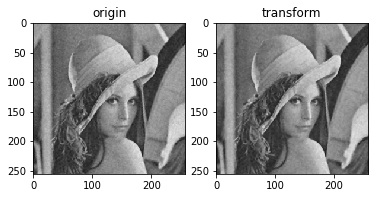

In [ ]:
noise_img = cv2.imread('preprocess/noise.png')
# 均值滤波
img_mean = cv2.blur(noise_img, (5,5))
show_img(noise_img, img_mean)
# 高斯滤波
img_gussian = cv2.GaussianBlur(noise_img, (5,5), 1)
show_img(noise_img, img_gussian)
# 中值滤波
img_median = cv2.medianBlur(noise_img, 5)
show_img(noise_img, img_median)
# 双边滤波
img_bilater = cv2.bilateralFilter(noise_img, 3, 15, 15)
show_img(noise_img, img_bilater)

基于邻域像素的滤波方法，基本上只考虑了滑动窗口范围内的像素灰度值信息，没有考虑该窗口内像素的统计信息如方差，也没有考虑整幅图像的像素分布特性，和噪声的先验知识。针对这些局限性，NLM算法被提出，该算法使用图像中的冗余信息来去噪声，在去噪的同时最大程度保留了图像的细节特征。NLM方法利用整幅图像进行去噪，以图像块为单位在图像中寻找相似区域，再对这些区域加权求平均，就可以获得去噪后的图像。其中相似度使用加权欧式距离计算，相似度越高，得到的权重越大。

## 4.2 变换域滤波

变换域滤波方法就是将图像从原始空间域转换到变换域；在变换域上从频率上把噪声分为高中低频噪声，用变换域的方法可以将不同频率的噪声分离；再进行反变换将图像从变换域转换到原始空间域，从而去除图像嗓声。将图像从空间域转换到变换域的方法很多，常见的算法有傅里叶变换、小波变换等。

傅里叶变换将输入图像从空间域转换到频域，包含低频和高频信息。图像上灰度值变化快的位置往往是图像中的噪声，对应着高频部分。那么使用傅里叶变化的低通滤波器，去除图像中的高频成分，只允许低频信息通过滤波器，从而达到去除图像噪声的目的。

小波变换去噪可以通过三个步骤进行：

1）图像的小波分解：选定一个小波和小波分解的层数N，对信号s进行N层小波分解；

2）对小波变换系数进行非线性阈值量化：对1~N层的每一层选择阈值，并对该层的高频系数进行量化处理，每层的低频系数不做处理；

3）小波系数重构：根据小波分解第N层的低频系数和经过处理后的1~N层的高频系数，计算原始信号的小波重构。小波变换去噪的关键在于阈值的选取，阈值函数分为硬阈值函数和软阈值函数。



## 4.3  BM3D

BM3D(Block-matching and 3D filtering)[21]融合了空间域滤波和变换域滤波方法，首先借鉴了NLM计算相似块的方法，然后又融合了小波变换去噪的方法。该算法通过相似判定找到相似块，并将相似快组合成三维群组。然后将三维群组变换到小波域，在小波域采用硬阈值或维纳滤波降低噪声。最后进行逆变换处理，聚合所有的图像块得到降噪后的图像。

## 4.4 深度学习

随着深度学习的发展，基于深度学习的去噪算法也不断涌现出来，基于CNN的去噪方法提高了去噪效果。常用的基于深度学习的算法有：DnCNNs[22]、FFDNet[23]、MPRNet[24]等。

DnCNNs(Denoising CNNs)首次将残差学习和批标准化引入图像去噪，两者的结合相互促进、有效地提高训练速度和去噪性能。FFDNet(Fast and Flexible Denoising NetWork)作用于下采样子图像，这加快了训练和测试的速度，也扩大了感受野，同时采用正交正则化方法提高泛化能力。MPRNet首先基于感受野较大的编码器-解码器子网络学习广泛的上下文相关的特征。然后进行高分辨率操作，从而在最终输出图像中保留所需的精细纹理。MPRNet可以应用在去雨、去模糊、去噪等多方向中。

# 五、总结

本节重点介绍了图像预处理中的数据增广、二值化和去噪的常用算法。第一，为了提升模型的鲁棒性，通常在训练样本上使用数据增广。我们介绍了四种不同的数据增广方法，包含：

1）标准数据增广：常用的旋转、透视变换、模糊、高斯噪声、随机裁剪等方法；

2）图像变换类：对RandCrop后的图像进行一些变换，主要包括AutoAugment、RandAugment、TimmAutoAugment；

3）图像裁剪类：对Transpose后的图像进行一些裁剪，并将裁剪区域的像素值置为特定的常数（默认为0），主要包括：CutOut、RandErasing、HideAndSeek、GridMask；

4）图像混叠：图像混叠主要对Batch后的数据进行混合，包括：Mixup、Cutmix。

第二，高质量的二值图像能够有效提升文字识别性能，主要介绍了全局阈值方法(固定阈值法、Otus)、局部阈值方法(自适应阈值法、NiBlack、Sauvola、Bernsen)和基于深度学习的方法(U-Net、Grid LSTM、全卷积神经网络等)。

第三，在大数据时代图像质量参差不齐，图像滤波应用越来越广泛，要求也将越来越高。对图像的一些去噪方法进行简单介绍，包含空间域滤波、变换域滤波、BM3D和基于深度学习的滤波方法。

# 参考文献

[1] Luo C, Zhu Y, Jin L, et al. Learn to augment: Joint data augmentation and network optimization for text recognition[C]//Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2020: 13746-13755.

[2] Cubuk E D, Zoph B, Mane D, et al. Autoaugment: Learning augmentation strategies from data[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2019: 113-123.

[3] Cubuk E D, Zoph B, Shlens J, et al. Randaugment: Practical automated data augmentation with a reduced search space[J]. arXiv preprint arXiv:1909.13719, 2019.

[4] DeVries T, Taylor G W. Improved regularization of convolutional neural networks with cutout[J]. arXiv preprint arXiv:1708.04552, 2017.

[5] Zhong Z, Zheng L, Kang G, et al. Random erasing data augmentation[J]. arXiv preprint arXiv:1708.04896, 2017.

[6] Singh K K, Lee Y J. Hide-and-seek: Forcing a network to be meticulous for weakly-supervised object and action localization[C]//2017 IEEE international conference on computer vision (ICCV). IEEE, 2017: 3544-3553.

[7] Chen P. GridMask Data Augmentation[J]. arXiv preprint arXiv:2001.04086, 2020.

[8] Zhang H, Cisse M, Dauphin Y N, et al. mixup: Beyond empirical risk minimization[J]. arXiv preprint arXiv:1710.09412, 2017.

[9] Yun S, Han D, Oh S J, et al. Cutmix: Regularization strategy to train strong classifiers with localizable features[C]//Proceedings of the IEEE International Conference on Computer Vision. 2019: 6023-6032.

[10] Otsu N. A threshold selection method from gray-level histograms[J]. IEEE transactions on systems, man, and cybernetics, 1979, 9(1): 62-66.

[11] Bradley D, Roth G. Adaptive thresholding using the integral image[J]. Journal of graphics tools, 2007, 12(2): 13-21.

[12] Niblack W. An introduction to digital image processing[M]. Strandberg Publishing Company, 1985

[13] Lazzara G, Géraud T. Efficient multiscale Sauvola’s binarization[J]. International Journal on Document Analysis and Recognition (IJDAR), 2014, 17(2): 105-123.

[14] Pratikakis I, Zagoris K, Barlas G, et al. ICDAR2017 competition on document image binarization (DIBCO 2017)[C]//2017 14th IAPR International Conference on Document Analysis and Recognition (ICDAR). IEEE, 2017, 1: 1395-1403.

[15] Tensmeyer C, Martinez T. Document image binarization with fully convolutional neural networks[C]//2017 14th IAPR international conference on document analysis and recognition (ICDAR). IEEE, 2017, 1: 99-104.

[16] Vo Q N, Kim S H, Yang H J, et al. Binarization of degraded document images based on hierarchical deep supervised network[J]. Pattern Recognition, 2018, 74: 568-586.

[17] Westphal F, Lavesson N, Grahn H. Document image binarization using recurrent neural networks[C]//2018 13th IAPR International Workshop on Document Analysis Systems (DAS). IEEE, 2018: 263-268.

[18] Calvo-Zaragoza J, Gallego A J. A selectional auto-encoder approach for document image binarization[J]. Pattern Recognition, 2019, 86: 37-47.

[19] Tomasi C, Manduchi R. Bilateral filtering for gray and color images[C]//Sixth international conference on computer vision (IEEE Cat. No. 98CH36271). IEEE, 1998: 839-846.

[20] Buades A, Coll B, Morel J M. A non-local algorithm for image denoising[C]//2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05). IEEE, 2005, 2: 60-65.

[21] Dabov K, Foi A, Katkovnik V, et al. Image denoising by sparse 3-D transform-domain collaborative filtering[J]. IEEE Transactions on image processing, 2007, 16(8): 2080-2095.

[22] Zhang K, Zuo W, Chen Y, et al. Beyond a gaussian denoiser: Residual learning of deep cnn for image denoising[J]. IEEE transactions on image processing, 2017, 26(7): 3142-3155.

[23] Zhang K, Zuo W, Zhang L. FFDNet: Toward a fast and flexible solution for CNN-based image denoising[J]. IEEE Transactions on Image Processing, 2018, 27(9): 4608-4622.

[24] Zamir S W, Arora A, Khan S, et al. Multi-stage progressive image restoration[C]//Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021: 14821-14831.